 # CRI Maximisation

 This notebook will carry n primary optimisation with intensities matched to the target intensity (n dim opt).
 I will explore, different cost functions and different optimisation strategies.

 The purpose was to be more mechanical with the optimisation process and not inject too much knowledge into it.
 IE trying to fit the shape of the D65 spectrum as accurately as possible.

### Imports

In [1]:
import warnings
import colour
from scipy.stats import norm
from scipy import optimize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

from bokeh.io import show, output_notebook, export_png
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Whisker
output_notebook()

Loading BokehJS ...

### Config

In [2]:
# Config parameters
figPath = "_plots"  # directory to save figures
touchDisk = False  # set this to true if you want to save figures to the disk. By default the script will not affect the file system on the host system
fullOptHistory = True #Set this to plot the full history of the cost functions during optimisation

# Change this to change the cost function
optimiseSpect_by = "criAndxyDiff_sequential"

warnings.simplefilter("ignore")
if touchDisk and not os.path.exists(figPath):
    os.makedirs(figPath)

### Utility functions

In [3]:
def generateMultiPrimarySpectrum(meanLambdas, fwhm_narrow=20):

    var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
    test_spectrum = np.zeros_like(target_wide_emission_wavelengths)

    for _, primaryLambda in enumerate(meanLambdas):
        primary_spectrum = norm.pdf(
            target_wide_emission_wavelengths, loc=primaryLambda, scale=var)
        primary_spectrum = target_wide_emission_SD[primaryLambda] * \
            primary_spectrum/np.max(primary_spectrum)
        test_spectrum += primary_spectrum

    test_spectrum_sd = colour.SpectralDistribution(
        test_spectrum, target_wide_emission_wavelengths)

    return test_spectrum_sd


def plotSpectChrCRI(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

    ax1.plot(target_wide_emission_wavelengths, test_spectrum_sd.values)
    ax1.plot(target_wide_emission_wavelengths,
             target_wide_emission_values, '--')
    ax1.set_ylabel("radiance w/m^2/sr")
    ax1.set_xlabel("wavelength (nm)")
    ax1.set_title(f'xy = [{test_spectrum_tristim_xy[0]:.3f},{test_spectrum_tristim_xy[1]:.3f}],d00 = {colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))):.3f}, CRI = {colour.colour_rendering_index(test_spectrum_sd):.3f}')
    colour.plotting.plot_chromaticity_diagram_CIE1931(
        standalone=False, cmfs='CIE 1931 2 Degree Standard Observer', axes=ax2)
    ax2.set_title("CIE 2' std. obs.")
    ax2.scatter(*test_spectrum_tristim_xy, s=200, color="red", marker="+")

    colour.plotting.plot_single_sd_colour_rendering_index_bars(
        test_spectrum_sd, standalone=False, axes=ax3)
    ax3.set_title("Individual CRIs")
    ax3.set_ylabel("CRI")
    ax3.set_xlabel("Test Sample Index")

    return fig

### Cost functions

In [4]:
def calcSpectAndCost_matchD65Int(meanLambdas, costFn):
    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    return costFn(test_spectrum_sd)


def nEmissionCostFn_xyDiff(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    return np.sum(np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))


def nEmissionCostFn_criDiff(test_spectrum_sd):
    return 1/colour.colour_rendering_index(test_spectrum_sd)


def nEmissionCostFn_criNormed(test_spectrum_sd):
    return 1/(10*np.log(np.exp(colour.colour_rendering_index(test_spectrum_sd)/10)+1))


def nEmissionCostFn_criAndxyDiff(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    return xyDiff + 1/np.clip(colour.colour_rendering_index(test_spectrum_sd), 0, 100)


def nEmissionCostFn_criNormAndxyDiff(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    return xyDiff + 1/(10*np.log(np.exp(colour.colour_rendering_index(test_spectrum_sd)/10)+1))


def nEmissionCostFn_criAndxyDiff_2(test_spectrum_sd):

    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    return 1.5*xyDiff - ((colour.colour_rendering_index(test_spectrum_sd)/100)-1)


def nEmissionCostFn_criAndxyDiffAndCRIdelta(test_spectrum_sd):

    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    #Qs = colour.colour_rendering_index(test_spectrum_sd,additional_data=True).Q_as.items()
    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    return 3*xyDiff - 2*((colour.colour_rendering_index(test_spectrum_sd)/100)-1) + np.sum(np.square(np.max(Q_as)/100 - np.min(Q_as)/100))


def nEmissionCostFn_DE00Diff(test_spectrum_sd):
    return colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD)))


cost_fn_lookup = {
    'xyDiff': nEmissionCostFn_xyDiff,
    'DE00Diff': nEmissionCostFn_DE00Diff,
    'criDiff': nEmissionCostFn_criDiff,
    'criAndxyDiff': nEmissionCostFn_criAndxyDiff,
    'criNormed': nEmissionCostFn_criNormed,
    'criNormAndxyDiff': nEmissionCostFn_criNormAndxyDiff,
    'criAndxyDiff_sequential': [nEmissionCostFn_xyDiff, nEmissionCostFn_criDiff],
    'nEmissionCostFn_criAndxyDiff_2': nEmissionCostFn_criAndxyDiff_2,
    'nEmissionCostFn_criAndxyDiffAndCRIdelta': nEmissionCostFn_criAndxyDiffAndCRIdelta,
}



def optimiseSpectrum(meanLambdas_0, optimiseSpect_by, optimiser='nelder-mead', bounds=None, iterativeOpt=False, staticLambdas=None):
    meanLambdas = meanLambdas_0

    try:
        if not "seq" in optimiseSpect_by:
            chosen_costFn = cost_fn_lookup[optimiseSpect_by]

            res = optimize.minimize(calcSpectAndCost_matchD65Int, meanLambdas_0,
                                    args=(chosen_costFn,),
                                    method=optimiser,
                                    bounds=bounds,
                                    options={'xatol': 1e-8, 'maxiter': 10000, 'disp': True, 'return_all': fullOptHistory})

            print(res.x)
            meanLambdas = res.x
            if fullOptHistory:
                allVecIterTrace.append(res.allvecs)

        else:
            for chosen_costFn in cost_fn_lookup[optimiseSpect_by]:
                res = optimize.minimize(calcSpectAndCost_matchD65Int, meanLambdas_0,
                                        args=(chosen_costFn,),
                                        method=optimiser,
                                        bounds=bounds,
                                        options={'xatol': 1e-8, 'disp': True, 'return_all': fullOptHistory})

                print(res.x)
                meanLambdas_0 = res.x

            meanLambdas = res.x

            if fullOptHistory:
                allVecIterTrace.append(res.allvecs)

    except KeyError as e:
        print(e)

    return meanLambdas

 # 1 - Pick target wide emission

 In this work because we are trying to find a spectrum for a white lighting source that maximise the CRI, we chose the CIE-D65 standard illuminant as the target.
 The aim was to see how well we can approximate that spectrum by using a finite number of QD LED sources.

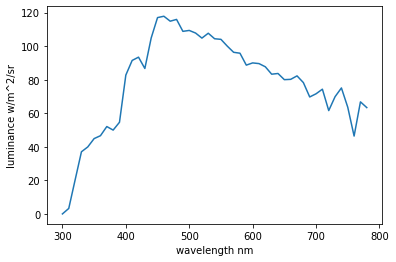

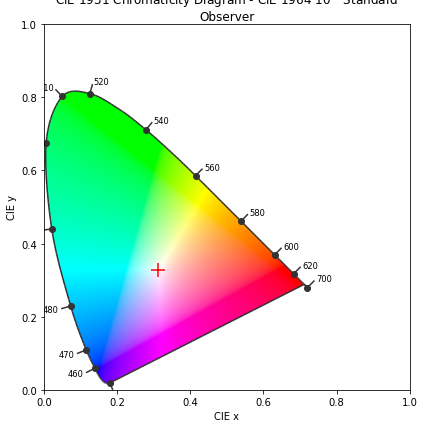

CRI = 99.99988846483116
Peak at = 460.0
Peak value = 117.812


In [5]:
target_wide_emission_SD = colour.SDS_ILLUMINANTS['D65']
target_wide_emission_values = colour.SDS_ILLUMINANTS['D65'].values
target_wide_emission_wavelengths = colour.SDS_ILLUMINANTS['D65'].wavelengths
target_wide_emission_tristim_xy = colour.XYZ_to_xy(
    colour.sd_to_XYZ(colour.SDS_ILLUMINANTS['D65']))
target_wide_emission_tristim_UCS = colour.xy_to_UCS_uv(
    target_wide_emission_tristim_xy)

plt.figure()
plt.plot(target_wide_emission_wavelengths, target_wide_emission_values)
plt.ylabel("luminance w/m^2/sr")
plt.xlabel("wavelength nm")

colour.plotting.plot_chromaticity_diagram_CIE1931(
    standalone=False, cmfs='CIE 1964 10 Degree Standard Observer')
plt.scatter(*target_wide_emission_tristim_xy, s=200, color="red", marker="+")
plt.show()

print(f"CRI = {colour.colour_rendering_index(colour.SDS_ILLUMINANTS['D65'])}")
print(
    f"Peak at = {target_wide_emission_wavelengths[np.argmax(target_wide_emission_values)]}")
print(f"Peak value = {np.max(target_wide_emission_values)}")

 # 2 - Single Wide emission match

 Create a single peak emission that has the same perceived colour as the target spectrum.
 Find the required lambda by minimising the cie-xy difference between target and the candidate spectrum.

Optimization terminated successfully.
         Current function value: 0.005353
         Iterations: 36
         Function evaluations: 76
CRI = 59.60788162473928
Peak at = 510.0
Peak value = 117.812
Delta E_00 = 42.947413287973475


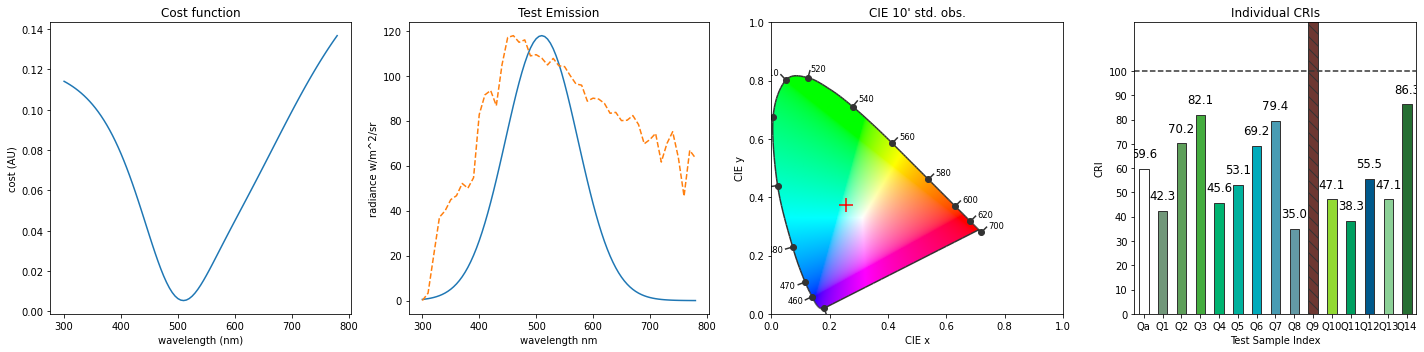

In [6]:
meanLambda_0 = 400 #initial value for the peak wavelength
fwhm_wide = 150 # wide emission FWHM
var = int(fwhm_wide)/(2*np.sqrt(2*np.log(2))) #variance of the peak spectral shape (assuming gaussian shape)
peakValue = np.max(target_wide_emission_values) #Peak luminance of the target spectrum

def wideEmissionCostFn(meanLambda):

    single_wideEmission = norm.pdf(
        target_wide_emission_wavelengths, loc=meanLambda, scale=var)
    single_wideEmission = peakValue * \
        single_wideEmission/np.max(single_wideEmission)

    single_wideEmission_sd = colour.SpectralDistribution(
        single_wideEmission, target_wide_emission_wavelengths)
    single_wideEmission_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(single_wideEmission_sd))

    return np.sum(np.square(target_wide_emission_tristim_xy - single_wideEmission_tristim_xy))


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.plot(target_wide_emission_wavelengths, [
         wideEmissionCostFn(x) for x in target_wide_emission_wavelengths])
ax1.set_title("Cost function")
ax1.set_ylabel("cost (AU)")
ax1.set_xlabel("wavelength (nm)")


res = optimize.minimize(wideEmissionCostFn, meanLambda_0, method='nelder-mead',
                        options={'xatol': 1e-8, 'disp': True})
meanLambda = res.x[0]

single_wideEmission = norm.pdf(
    target_wide_emission_wavelengths, loc=meanLambda, scale=var)
single_wideEmission = peakValue * \
    single_wideEmission/np.max(single_wideEmission)

single_wideEmission_sd = colour.SpectralDistribution(
    single_wideEmission, target_wide_emission_wavelengths)
single_wideEmission_tristim_xy = colour.XYZ_to_xy(
    colour.sd_to_XYZ(single_wideEmission_sd))

ax2.set_title("Test Emission")
ax2.plot(target_wide_emission_wavelengths, single_wideEmission)
ax2.plot(target_wide_emission_wavelengths, target_wide_emission_values, '--')
ax2.set_ylabel("radiance w/m^2/sr")
ax2.set_xlabel("wavelength nm")

colour.plotting.plot_chromaticity_diagram_CIE1931(
    standalone=False, cmfs='CIE 1964 10 Degree Standard Observer', axes=ax3)
ax3.scatter(*single_wideEmission_tristim_xy, s=200, color="red", marker="+")
ax3.set_title("CIE 10' std. obs.")
colour.plotting.plot_single_sd_colour_rendering_index_bars(
    single_wideEmission_sd, standalone=False, axes=ax4)
ax4.set_title("Individual CRIs")
ax4.set_ylabel("CRI")
ax4.set_xlabel("Test Sample Index")
fig.show()

if touchDisk:
    fig.savefig(os.path.join(figPath, "wideE"))

print(f"CRI = {colour.colour_rendering_index(single_wideEmission_sd)}")
print(
    f"Peak at = {target_wide_emission_wavelengths[np.argmax(single_wideEmission)]}")
print(f"Peak value = {np.max(single_wideEmission)}")
print(f"Delta E_00 = {colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(single_wideEmission_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD)))}")


 ---
 ## 3 - Uniformly distributed primaries (Without Optimisation) (only as an example)

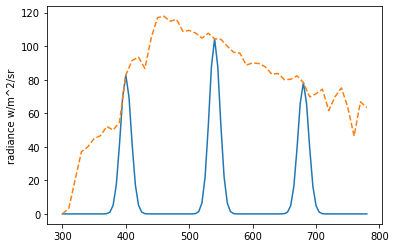

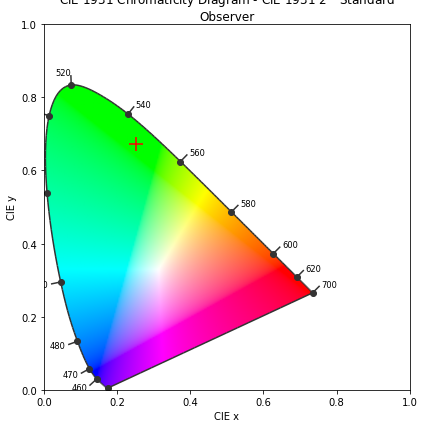

In [7]:
# Config
n_primaries = 3
fwhm_narrow = 20

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))

meanLambdas_0 = np.linspace(np.min(target_wide_emission_wavelengths) +
                            100, np.max(target_wide_emission_wavelengths)-100, n_primaries)

test_spectrum = np.zeros_like(target_wide_emission_wavelengths)
for p_idx in range(n_primaries):
    primary_spectrum = norm.pdf(
        target_wide_emission_wavelengths, loc=meanLambdas_0[p_idx], scale=var)
    primary_spectrum = target_wide_emission_SD[meanLambdas_0[p_idx]
                                               ] * primary_spectrum/np.max(primary_spectrum)
    test_spectrum += primary_spectrum

test_spectrum_sd = colour.SpectralDistribution(
    test_spectrum, target_wide_emission_wavelengths)

test_spectrum_tristim_xy = colour.XYZ_to_xy(colour.sd_to_XYZ(test_spectrum_sd))

plt.plot(target_wide_emission_wavelengths, test_spectrum)
plt.plot(target_wide_emission_wavelengths, target_wide_emission_values, '--')

plt.ylabel("radiance w/m^2/sr")

colour.plotting.plot_chromaticity_diagram_CIE1931(
    standalone=False, cmfs='CIE 1931 2 Degree Standard Observer')
plt.scatter(*test_spectrum_tristim_xy, s=200, color="red", marker="+")
plt.show()

 ## 4 - Uniform Prior - tune wthout constraints

 Start with uniformly primaries, then adjust lambda till the xy matches the target spectrum. This is minimising the difference between xy values

criAndxyDiff_sequential
Optimising for 3 primaries.
Initial Peak Wavelengths = [ 330.  516.  702.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 162
         Function evaluations: 296
[ 395.82679386  576.37967561  478.48070384]
[ 411.86558565  590.38841744  469.79143274]
Optimised Peak Wavelengths = [ 411.86558565  590.38841744  469.79143274]
Optimised Radiances = [91.849005656409219, 88.736894406955983, 114.92252734293096]
cri = -8.881784197001252e-15. (min = -169.7170380870893. max =39.777594683593584)
Optimising for 4 primaries.
Initial Peak Wavelengths = [ 330.  454.  578.  702.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 169
         Function evaluations: 319
[ 332.80054883  477.81905477  575.64421182  688.32297261]
Optimization terminated successfully.
         Current function value: -40210710958665.140625
         Iterations: 242
         Function evaluations: 539
[ 

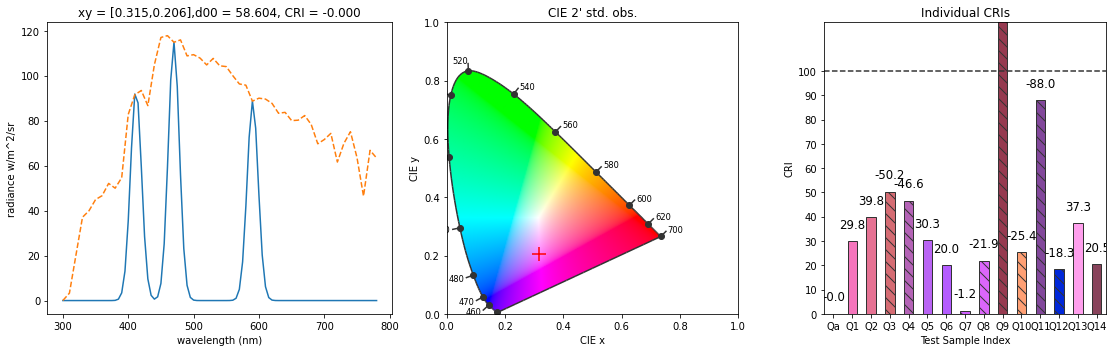

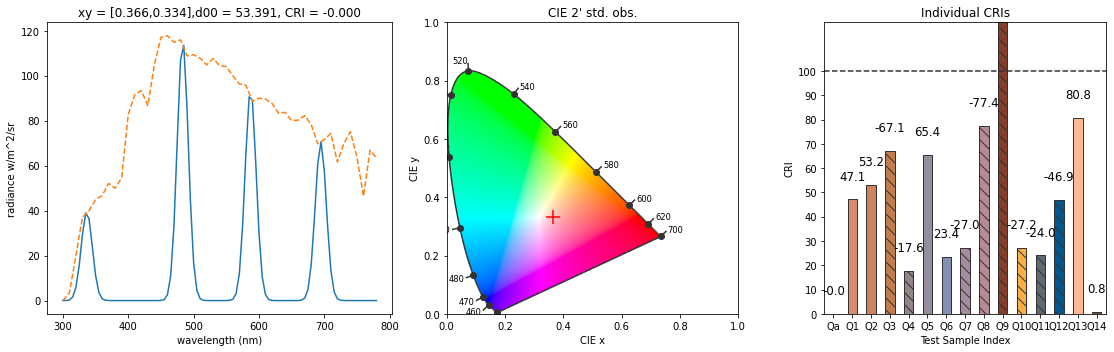

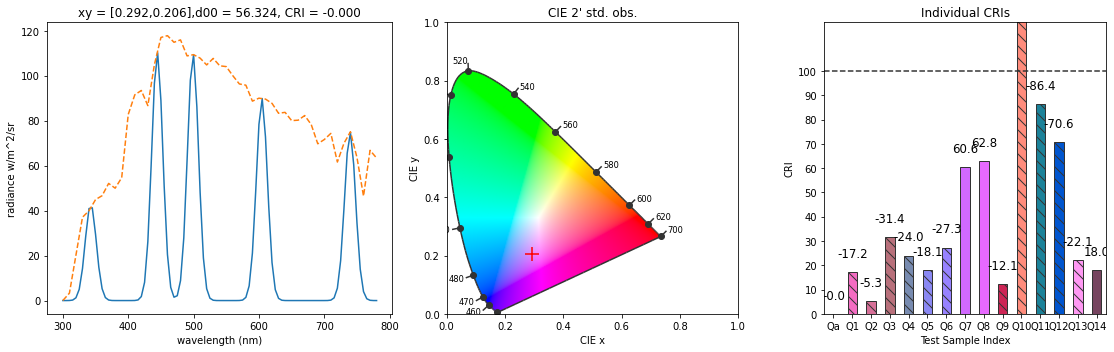

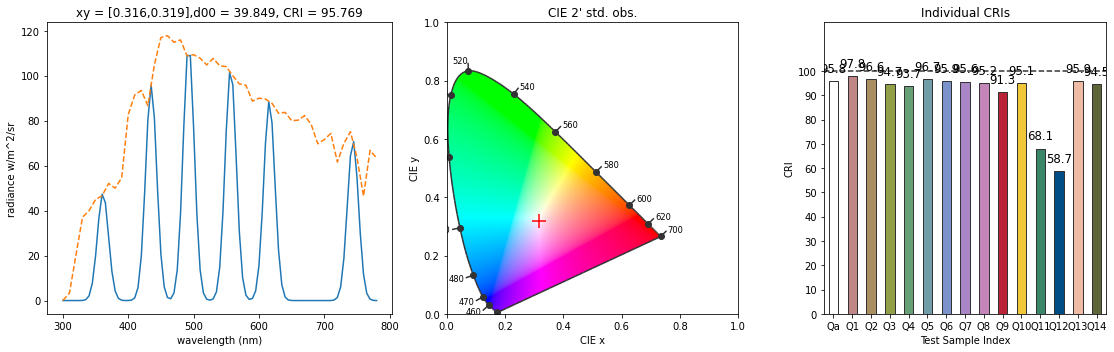

In [8]:
n_primaries = 6
fwhm_narrow = 20

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
optimiseSpect = True
# optimiseSpect_by = "criAndxyDiff_sequential"
print(optimiseSpect_by)
decomposition_list = []


if fullOptHistory:
    allVecIterTrace = []

for n_primaries in range(3, n_primaries+1):
    print(f"Optimising for {n_primaries} primaries.")
    meanLambdas_0 = np.linspace(np.min(target_wide_emission_wavelengths)
                                * 1.1, np.max(target_wide_emission_wavelengths)*0.9, n_primaries)
    print("Initial Peak Wavelengths =", meanLambdas_0)

    if optimiseSpect:
        meanLambdas = optimiseSpectrum(meanLambdas_0, optimiseSpect_by)

    else:
        meanLambdas = meanLambdas_0

    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig = plotSpectChrCRI(test_spectrum_sd)
    fig.show()

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    print(f"Optimised Peak Wavelengths = {meanLambdas}")
    print(
        f"Optimised Radiances = {[target_wide_emission_SD[lam] for lam in meanLambdas]}")
    print(f"cri = {colour.colour_rendering_index(test_spectrum_sd)}. (min = {np.min(Q_as)}. max ={np.max(Q_as)})")

    if touchDisk:
        fig.savefig(os.path.join(
            figPath, f"narrowE_unif_p={n_primaries}_{optimiseSpect_by}"))

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    decomposition_list.append({
        'spectRadiance': test_spectrum_sd.values,
        'n_primaries': n_primaries,
        'cie_xy': test_spectrum_tristim_xy,
        'E_00': colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'E_94': colour.difference.delta_E_CIE1994(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'Q_as': Q_as,
        'Q_as_max': np.max(Q_as),
        'Q_as_min': np.min(Q_as),
        'cri': colour.colour_rendering_index(test_spectrum_sd),
        'error': np.sum(np.abs(target_wide_emission_SD.values-test_spectrum_sd.values)),
    })

decomposition = pd.DataFrame(decomposition_list)


In [9]:
sz = 7
alp = 0.8

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_00")
p.scatter(x='n_primaries', y='E_00', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E00.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_94")
p.scatter(x='n_primaries', y='E_94', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E94.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="CRI")
p.add_layout(Whisker(source=ColumnDataSource(decomposition),
             base="n_primaries", upper="Q_as_max", lower="Q_as_min"))
p.scatter(x='n_primaries', y='cri', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=colour.colour_rendering_index(
    target_wide_emission_SD), line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_CRI.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Spectral MAE")
p.add_layout(Whisker(source=ColumnDataSource(
    decomposition), base="n_primaries"))
p.scatter(x='n_primaries', y='error', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
# p.line(x=decomposition['n_primaries'], y= colour.colour_rendering_index(target_wide_emission_SD),line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_MAE.png"))

decomposition


,spectRadiance,n_primaries,cie_xy,E_00,E_94,Q_as,Q_as_max,Q_as_min,cri,error
0,"[2.00877388301e-36, 3.93698020138e-33, 5.45607...",3,"[0.315246876569, 0.206071775494]",58.604396,1148.270205,"[29.8034296746, 39.7775946836, -50.2092873488,...",39.777595,-169.717038,-8.881784e-15,6338.729472
1,"[0.00382391696851, 0.0404213383329, 0.30213283...",4,"[0.366397961603, 0.333763319155]",53.391031,1061.983488,"[47.1073494258, 53.1824797935, -67.1423549405,...",80.835155,-274.486707,-2.486900e-14,6248.666735
2,"[0.000146594409961, 0.00236401901132, 0.026956...",5,"[0.292168352617, 0.206270132628]",56.324033,1072.639134,"[-17.2424596266, -5.29335793966, -31.423609424...",62.818814,-195.733239,-1.776357e-15,5784.414806
3,"[2.37719765966e-10, 1.39794873836e-08, 5.81302...",6,"[0.315808916347, 0.318910414381]",39.849369,746.155575,"[97.7977907325, 96.5682665016, 94.7033372359, ...",97.797791,58.693190,9.576917e+01,5390.985813


 ## 5 - CMF range Prior - tune wthout constraints

 Start with the primaries spread between the LMS cone fundamentals and then adjust lambda till the xy matches the target spectrum. This is minimising the difference between xy values

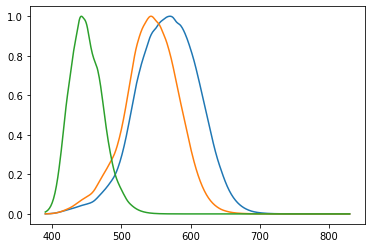

In [10]:
chosen_cmf = colour.MSDS_CMFS['Stockman & Sharpe 2 Degree Cone Fundamentals']
# chosen_cmf = colour.colorimetry.LMS_ConeFundamentals
plt.plot(chosen_cmf.wavelengths,chosen_cmf.values)
lambdaPeaks = [chosen_cmf.wavelengths[np.argmax(
    x)] for x in chosen_cmf.values.transpose()]


criAndxyDiff_sequential
Optimising for 3 primaries.
Initial Peak Wavelengths = [ 419.9   523.45  627.  ]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 146
         Function evaluations: 277
[ 440.92309212  538.73457672  594.00645344]
Optimization terminated successfully.
         Current function value: 0.011818
         Iterations: 216
         Function evaluations: 417
[ 462.7466568  532.5        600.9046053]
Optimised Peak Wavelengths = [ 462.7466568  532.5        600.9046053]
Optimised Radiances = [117.00118691208955, 106.86800000077551, 89.96936447220304]
cri = 84.61915792552233. (min = -67.99370945517657. max =99.2804048462936)
Optimising for 4 primaries.
Initial Peak Wavelengths = [ 419.9         488.93333333  557.96666667  627.        ]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 157
         Function evaluations: 306
[ 434.99509243  492.52751465  552.14427294  612.18

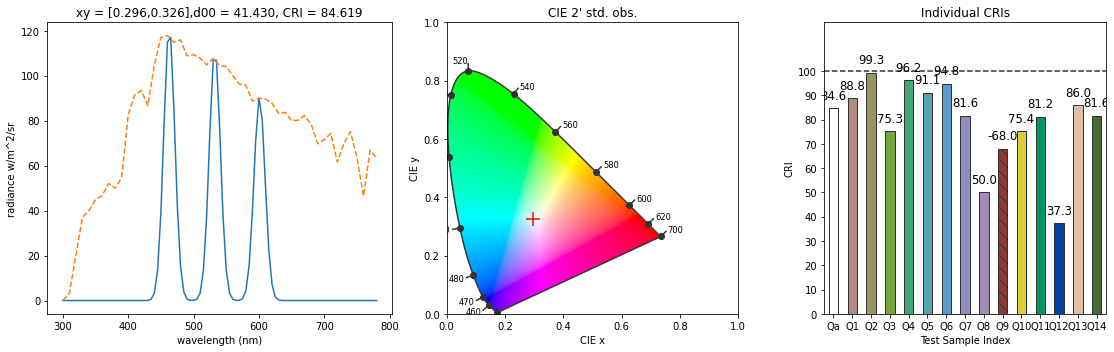

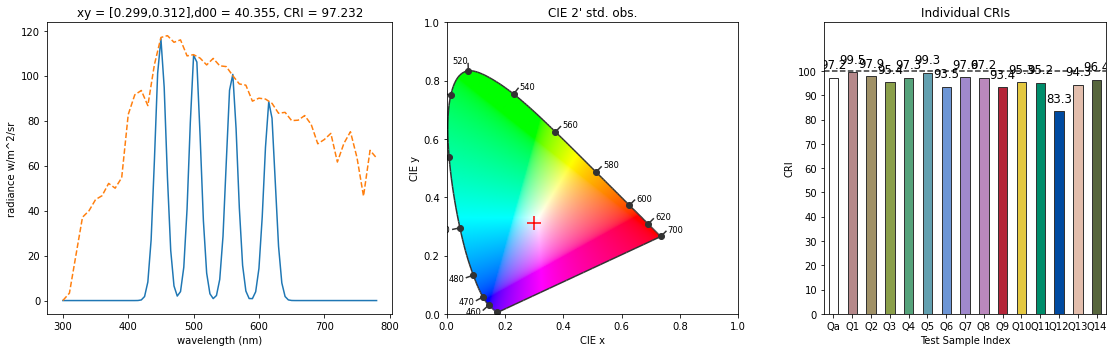

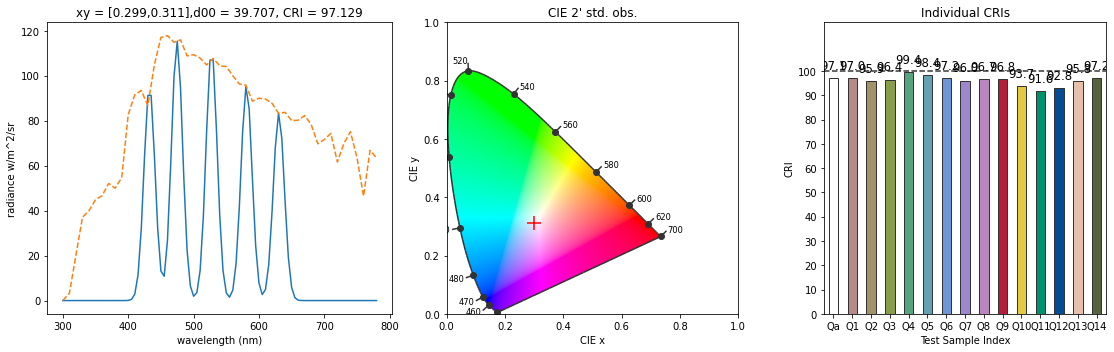

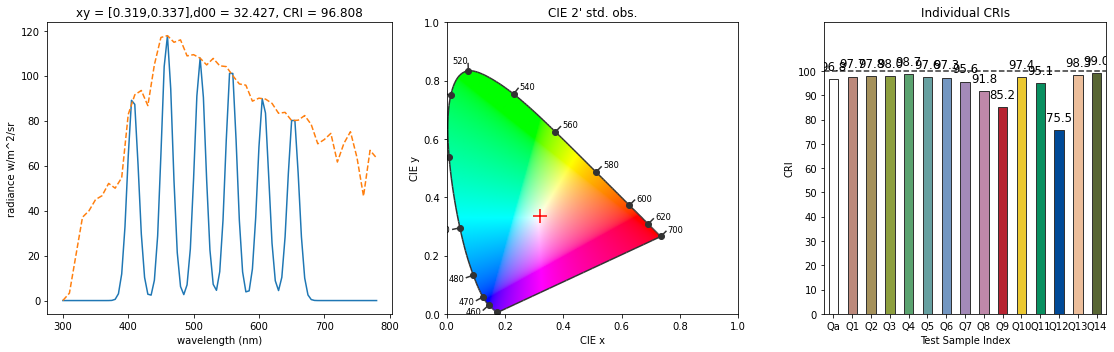

In [11]:
n_primaries = 6
fwhm_narrow = 20

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
optimiseSpect = True
# optimiseSpect_by = "nEmissionCostFn_criAndxyDiff_2"
print(optimiseSpect_by)
decomposition_list = []

# colour.STANDARD_OBSERVERS_CMFS['cie_2_1931']
chosen_cmf = colour.MSDS_CMFS['Stockman & Sharpe 2 Degree Cone Fundamentals']
lambdaPeaks = [chosen_cmf.wavelengths[np.argmax(
    x)] for x in chosen_cmf.values.transpose()]

if fullOptHistory:
    allVecIterTrace = []

for n_primaries in range(3, n_primaries+1):
    print(f"Optimising for {n_primaries} primaries.")

    meanLambdas_0 = np.linspace(
        np.min(lambdaPeaks)*0.95, np.max(lambdaPeaks)*1.1, n_primaries)
    print("Initial Peak Wavelengths =",meanLambdas_0)
    if optimiseSpect:
        meanLambdas = optimiseSpectrum(meanLambdas_0, optimiseSpect_by)

    else:
        meanLambdas = meanLambdas_0

    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig = plotSpectChrCRI(test_spectrum_sd)
    fig.show()

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    print(f"Optimised Peak Wavelengths = {meanLambdas}")
    print(
        f"Optimised Radiances = {[target_wide_emission_SD[lam] for lam in meanLambdas]}")
    print(f"cri = {colour.colour_rendering_index(test_spectrum_sd)}. (min = {np.min(Q_as)}. max ={np.max(Q_as)})")

    if touchDisk:
        fig.savefig(os.path.join(
            figPath, f"narrowE_unif_p={n_primaries}_{optimiseSpect_by}"))

    decomposition_list.append({
        'spectRadiance': test_spectrum_sd.values,
        'n_primaries': n_primaries,
        'cie_xy': test_spectrum_tristim_xy,
        'E_00': colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'E_94': colour.difference.delta_E_CIE1994(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'Q_as': Q_as,
        'Q_as_max': np.max(Q_as),
        'Q_as_min': np.min(Q_as),
        'cri': colour.colour_rendering_index(test_spectrum_sd),
        'error': np.sum(np.abs(target_wide_emission_SD.values-test_spectrum_sd.values)),
    })

decomposition = pd.DataFrame(decomposition_list)


In [12]:
sz = 7
alp = 0.8

p = figure(plot_width=300, plot_height=300,
           x_axis_label="number of primaries", y_axis_label="Delta E_00")
p.scatter(x='n_primaries', y='E_00', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E00.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_94")
p.scatter(x='n_primaries', y='E_94', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E94.png"))

p = figure(plot_width=300, plot_height=300,
           x_axis_label="number of primaries", y_axis_label="CRI", y_range=[50, 102])
p.add_layout(Whisker(source=ColumnDataSource(decomposition),
             base="n_primaries", upper="Q_as_max", lower="Q_as_min"))
p.scatter(x='n_primaries', y='cri', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=colour.colour_rendering_index(
    target_wide_emission_SD), line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_CRI.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Spectral MAE")
p.add_layout(Whisker(source=ColumnDataSource(
    decomposition), base="n_primaries"))
p.scatter(x='n_primaries', y='error', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
# p.line(x=decomposition['n_primaries'], y= colour.colour_rendering_index(target_wide_emission_SD),line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_MAE.png"))

decomposition


,spectRadiance,n_primaries,cie_xy,E_00,E_94,Q_as,Q_as_max,Q_as_min,cri,error
0,"[2.24513673239e-78, 1.49674506744e-73, 7.05566...",3,"[0.295586645316, 0.326020493392]",41.429929,776.964332,"[88.7692826532, 99.2804048463, 75.2588919299, ...",99.280405,-67.993709,84.619158,6232.624753
1,"[5.57937274238e-66, 1.48949293048e-61, 2.81174...",4,"[0.299153868881, 0.312060590878]",40.355363,696.697925,"[99.5072830315, 97.9257993475, 95.4432475323, ...",99.507283,83.342537,97.232139,5816.923384
2,"[1.34698744454e-51, 1.10345212686e-47, 6.39187...",5,"[0.299190805103, 0.310873296358]",39.706514,623.466611,"[96.982213448, 95.8593696758, 96.4314249617, 9...",99.418327,91.552967,97.129022,5481.182370
3,"[2.32262913128e-33, 3.29586849364e-30, 3.30708...",6,"[0.318761031763, 0.337020829085]",32.427316,578.387381,"[97.6578842156, 97.7915537322, 98.002338814, 9...",98.969378,75.535785,96.807958,5064.854859


 ## 6 - Constrained optimisation to the CMF Range


Optimising for 3 primaries.
Initial Peak Wavelengths = [ 356.  538.  720.]
Optimization terminated successfully.
         Current function value: 0.063747
         Iterations: 5
         Function evaluations: 44
         Gradient evaluations: 11
[ 356.15850893  576.68936179  719.58498605]
         Current function value: -0.030511
         Iterations: 6
         Function evaluations: 452
         Gradient evaluations: 110
[ 366.38154984  580.95228037  716.86852665]
Optimised Peak Wavelengths = [ 366.38154984  580.95228037  716.86852665]
Optimised Radiances = [50.116755185232066, 95.111652393367407, 65.595062788350745]
cri = -32.775571137289106. (min = -462.66619129004994. max =52.8665264273342)
Optimising for 4 primaries.
Initial Peak Wavelengths = [ 356.          477.33333333  598.66666667  720.        ]
         Current function value: 0.004755
         Iterations: 9
         Function evaluations: 542
         Gradient evaluations: 106
[ 355.99801932  482.5         595.10989885  720.

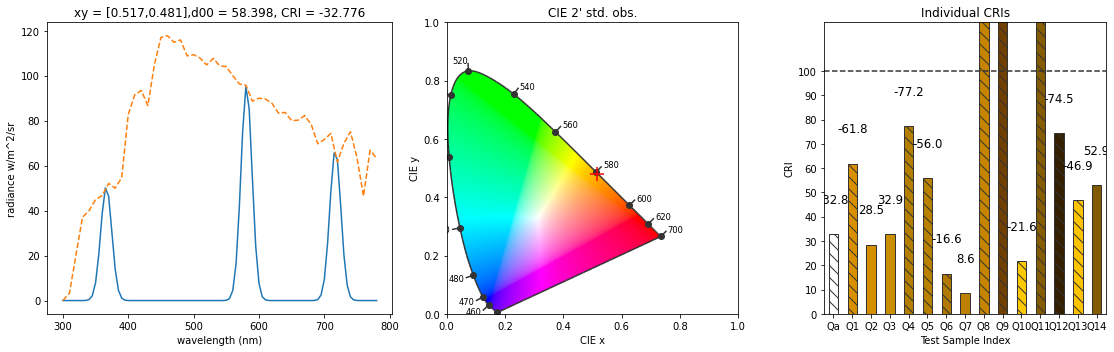

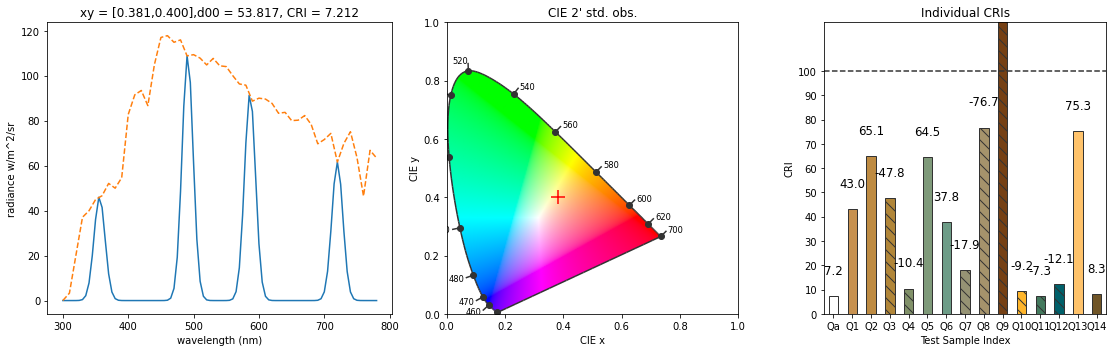

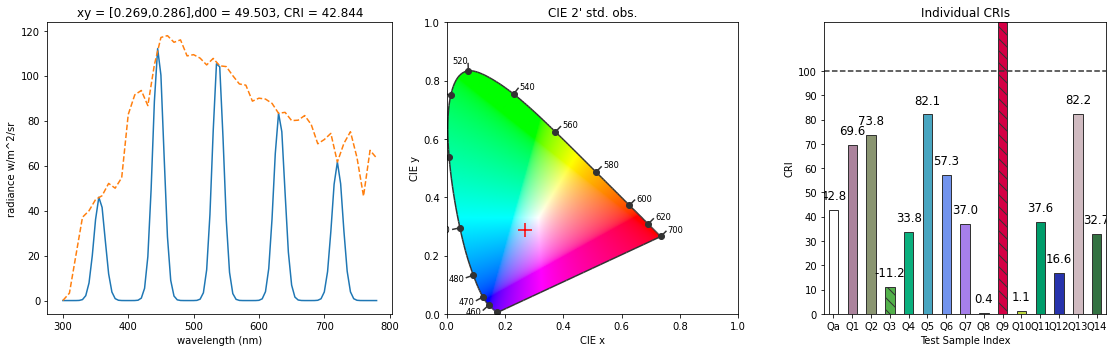

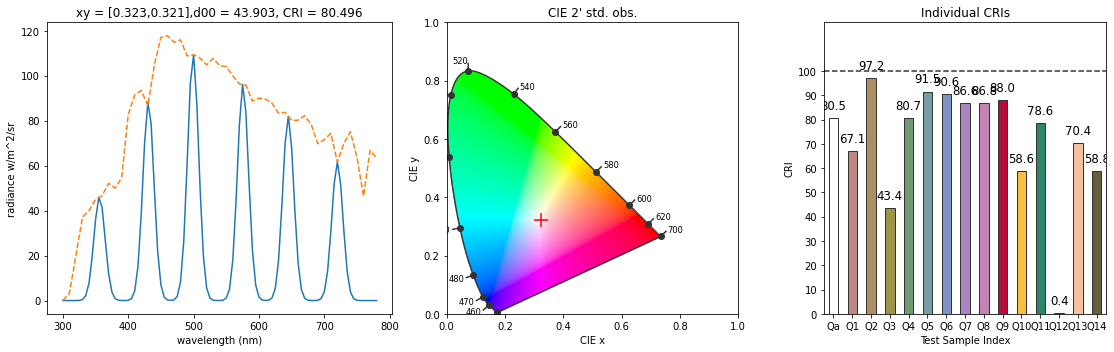

In [13]:
n_primaries = 6
fwhm_narrow = 30

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
optimiseSpect = True
# optimiseSpect_by = 'criAndxyDiff_sequential'
decomposition_list = []

chosen_cmf = colour.colorimetry.MSDS_CMFS_STANDARD_OBSERVER['cie_2_1931']
chosen_cmf.align(colour.quality.SDS_TCS['TCS01'].shape)
lambdaPeaks = [chosen_cmf.wavelengths[np.argmax(
    x)] for x in chosen_cmf.values.transpose()]


if fullOptHistory:
    allVecIterTrace = []

for n_primaries in range(3, n_primaries+1):
    print(f"Optimising for {n_primaries} primaries.")
    meanLambdas_0 = np.linspace(
        np.min(lambdaPeaks)*0.8, np.max(lambdaPeaks)*1.2, n_primaries)
    print("Initial Peak Wavelengths =", meanLambdas_0)

    if optimiseSpect:
        meanLambdas = optimiseSpectrum(meanLambdas_0, optimiseSpect_by, optimiser='BFGS', bounds=(
            [(np.min(lambdaPeaks)*0.9, np.min(lambdaPeaks)*1.3)]*n_primaries))

    else:
        meanLambdas = meanLambdas_0

    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig = plotSpectChrCRI(test_spectrum_sd)
    fig.show()

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    print(f"Optimised Peak Wavelengths = {meanLambdas}")
    print(
        f"Optimised Radiances = {[target_wide_emission_SD[lam] for lam in meanLambdas]}")
    print(f"cri = {colour.colour_rendering_index(test_spectrum_sd)}. (min = {np.min(Q_as)}. max ={np.max(Q_as)})")

    if touchDisk:
        fig.savefig(os.path.join(
            figPath, f"narrowE_cmfPrior_p={n_primaries}_{fwhm_narrow}nm_{optimiseSpect_by}"))

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    decomposition_list.append({
        'spectRadiance': test_spectrum_sd.values,
        'n_primaries': n_primaries,
        'cie_xy': test_spectrum_tristim_xy,
        'E_00': colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'E_94': colour.difference.delta_E_CIE1994(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'Q_as': Q_as,
        'Q_as_max': np.max(Q_as),
        'Q_as_min': np.min(Q_as),
        'cri': colour.colour_rendering_index(test_spectrum_sd),
        'error': np.sum(np.abs(target_wide_emission_SD.values-test_spectrum_sd.values)),
    })

decomposition = pd.DataFrame(decomposition_list)


In [14]:
sz = 7
alp = 0.8

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_00")
p.scatter(x='n_primaries', y='E_00', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_E00.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_94")
p.scatter(x='n_primaries', y='E_94', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_E94.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="CRI")
p.add_layout(Whisker(source=ColumnDataSource(decomposition),
             base="n_primaries", upper="Q_as_max", lower="Q_as_min"))
p.scatter(x='n_primaries', y='cri', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=colour.colour_rendering_index(
    target_wide_emission_SD), line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_CRI.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Spectral MAE")
p.add_layout(Whisker(source=ColumnDataSource(
    decomposition), base="n_primaries"))
p.scatter(x='n_primaries', y='error', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
# p.line(x=decomposition['n_primaries'], y= colour.colour_rendering_index(target_wide_emission_SD),line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_MAE.png"))

decomposition

,spectRadiance,n_primaries,cie_xy,E_00,E_94,Q_as,Q_as_max,Q_as_min,cri,error
0,"[2.7593786775e-12, 2.31120022493e-10, 1.368827...",3,"[0.517444648711, 0.48102759536]",58.398339,1126.938365,"[-61.7892711093, 28.4956958142, 32.8505915513,...",52.866526,-462.666191,-32.775571,6700.080227
1,"[1.68106013088e-08, 6.85548170754e-07, 1.97686...",4,"[0.381245979554, 0.399505238954]",53.816695,1035.843796,"[42.9699402598, 65.1012303212, -47.786847663, ...",75.263023,-311.223896,7.212485,6288.031535
2,"[1.68018365831e-08, 6.85223386052e-07, 1.97602...",5,"[0.269171077527, 0.28601414051]",49.503240,913.710104,"[69.6197368903, 73.7792185325, -11.2089829107,...",82.200316,-127.901939,42.844484,5847.125242
3,"[1.67303531145e-08, 6.8257392386e-07, 1.969152...",6,"[0.323382241251, 0.321119074484]",43.902865,870.731738,"[67.0507650702, 97.2481786939, 43.4100089302, ...",97.248179,0.397454,80.496189,5547.159807
